In [ ]:
pip install torch numpy matplotlib scikit-learn

In [2]:
# Import required libraries
import torch  # PyTorch main package
import torch.nn as nn  # Neural network modules
import torch.optim as optim  # Optimization algorithms
import numpy as np  # Numerical computations
import matplotlib.pyplot as plt  # Plotting library
from sklearn.datasets import make_regression  # To generate synthetic regression data
from sklearn.model_selection import train_test_split  # To split data into train/test sets
from sklearn.preprocessing import StandardScaler  # To standardize data

In [3]:
# 1. Generate synthetic regression data
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)  # Generate 1000 samples with 10 features and Gaussian noise
y = y.reshape(-1, 1)  # Reshape y from shape (1000,) to (1000, 1) to match PyTorch expectations

In [4]:
# 2. Split and scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Split 80% train, 20% test

# Initialize scalers for X and y
scaler_X = StandardScaler()  # Create a scaler for features
X_train = scaler_X.fit_transform(X_train)  # Fit to training data and transform it
X_test = scaler_X.transform(X_test)  # Apply the same transformation to test data

scaler_y = StandardScaler()  # Create a scaler for the target
y_train = scaler_y.fit_transform(y_train)  # Standardize training targets
y_test = scaler_y.transform(y_test)  # Standardize test targets

# Convert NumPy arrays into PyTorch tensors for training
X_train = torch.FloatTensor(X_train)  # Convert training features to float tensor
X_test = torch.FloatTensor(X_test)  # Convert test features to float tensor
y_train = torch.FloatTensor(y_train)  # Convert training targets to float tensor
y_test = torch.FloatTensor(y_test)  # Convert test targets to float tensor

In [5]:
# 3. Define the neural network architecture
class RegressionNN(nn.Module):  # Inherit from nn.Module
    def __init__(self, input_size):  # Constructor takes number of input features
        super(RegressionNN, self).__init__()  # Call parent constructor
        self.fc1 = nn.Linear(input_size, 64)  # First fully connected layer (input -> 64)
        self.fc2 = nn.Linear(64, 32)  # Second fully connected layer (64 -> 32)
        self.fc3 = nn.Linear(32, 1)  # Output layer (32 -> 1)
        self.relu = nn.ReLU()  # ReLU activation function

    def forward(self, x):  # Define forward pass
        x = self.relu(self.fc1(x))  # Apply first layer + ReLU
        x = self.relu(self.fc2(x))  # Apply second layer + ReLU
        x = self.fc3(x)  # Output layer (no activation for regression)
        return x  # Return prediction

In [6]:
# 4. Initialize model, loss function, and optimizer
input_size = X_train.shape[1]  # Determine number of input features (should be 10)
model = RegressionNN(input_size)  # Instantiate the model
criterion = nn.MSELoss()  # Use Mean Squared Error loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Use Adam optimizer with learning rate 0.001

In [ ]:
# 5. Train the model
epochs = 200  # Number of training epochs
train_losses = []  # Store training loss each epoch
test_losses = []  # Store test loss each epoch

for epoch in range(epochs):  # Loop through each epoch
    # Training phase
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Clear existing gradients
    outputs = model(X_train)  # Forward pass on training data
    loss = criterion(outputs, y_train)  # Compute loss between prediction and target
    loss.backward()  # Backpropagation to compute gradients
    optimizer.step()  # Update model weights
    train_losses.append(loss.item())  # Save training loss

    # Evaluation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for efficiency
        test_outputs = model(X_test)  # Predict on test set
        test_loss = criterion(test_outputs, y_test)  # Compute test loss
        test_losses.append(test_loss.item())  # Save test loss

    # Print progress every 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

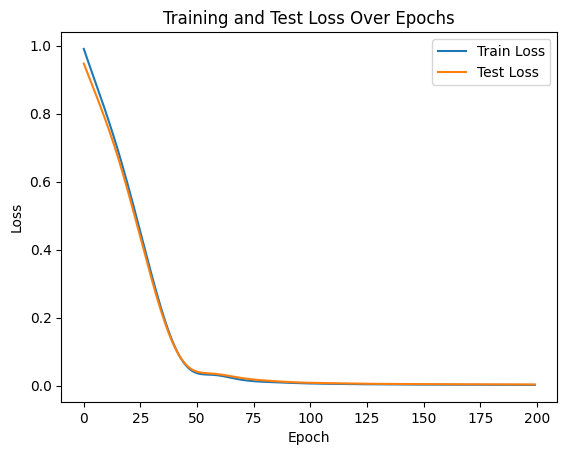

In [8]:
# 6. Plot training and test loss curves
plt.plot(train_losses, label='Train Loss')  # Plot training loss over epochs
plt.plot(test_losses, label='Test Loss')  # Plot test loss over epochs
plt.xlabel('Epoch')  # Label x-axis
plt.ylabel('Loss')  # Label y-axis
plt.legend()  # Show legend
plt.title('Training and Test Loss Over Epochs')  # Title for the plot
plt.show()  # Display the plot

In [ ]:
# 7. Make predictions on a few samples
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradients
    sample_input = X_test[0:5]  # Select first 5 samples from test set
    predictions = model(sample_input)  # Get model predictions
    actual = y_test[0:5]  # Get actual target values

    print("\nSample Predictions vs Actual:")  # Header for comparison
    for i in range(5):  # Loop over 5 samples
        print(f"Predicted: {predictions[i].item():.4f}, Actual: {actual[i].item():.4f}")  # Print prediction vs actual

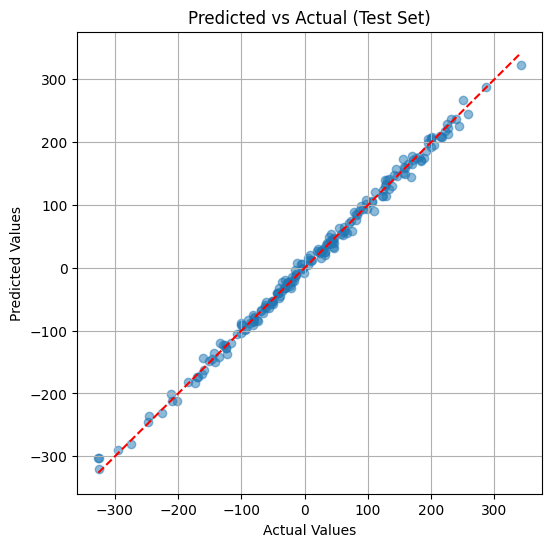

In [10]:
# 8. Plot predictions vs actual values on test set
with torch.no_grad():
    y_pred_all = model(X_test).numpy()
    y_actual_all = y_test.numpy()

# 反标准化以恢复原始值（可选）
y_pred_all = scaler_y.inverse_transform(y_pred_all)
y_actual_all = scaler_y.inverse_transform(y_actual_all)

# Plotting
plt.figure(figsize=(6,6))
plt.scatter(y_actual_all, y_pred_all, alpha=0.5)
plt.plot([y_actual_all.min(), y_actual_all.max()],
         [y_actual_all.min(), y_actual_all.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual (Test Set)")
plt.grid(True)
plt.show()